# DSCI 100 Project: Predicting Heart Disease Diagnoses with Data and Classification Models


# Introduction:

Everyone has at some point heard, either from a doctor or a person who has visited one, about the risk factors that lead to heart disease. Most professionals cite things like blood pressure, obesity, blood sugar level, diabetes, blood-cholesterol concentration and the like as factors that cause heart disease. With this in mind, we'll be working with the UC Irvine Heart Disease dataset to answer our question: **Can age, cholesterol levels and maximum heart rate be used to predict a heart disease diagnosis using K-NN classification?**
We are expecting cholesterol levels and maximum heart rate to impact a heart diagnosis the most, however we are including age as a predictor since we hypothesisze that it may be a secondary factor that most professionals do not cite.


The dataset contains fourteen variables age, sex, chest pain type, resting blood pressure in mmHg(millimeters of mercury), cholesterol levels in mg/dl(milligrams per deciliter), whether the patient's fasting blood sugar is above 120mg/dl, type of resting electrocardiographic results, patient's maximum heart rate(bpm), whether exercise induced chest pain in a patient, the ST depression induced by exercise, the slope of the ST segment at peak exercise, the amount of blood vessels analyzed for a patient, whether the patient has Thalassemia(blood disorder), and finally heart disease diagnosis.

# Methods and Results

We will now conduct the data analysis, explaining every step as we go...

**Downloading libaraies and setting the seed**

In [1]:
#ESSENTIAL LIBRARIES AND SEED STUFF
set.seed(2000) #NEVER CHANGE
library(tidyverse)
library(tidymodels)
library(GGally)
library(repr)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

**Reading in our data from the web and cleaning**
(returns a sample at the end to show tidy format)

In [2]:
#Dataset reading
col_names <-c("age", "sex", "chest_pain_type", "resting_blood_pressure", "cholesterol_concentration", "fasting_blood_sugar_greater",
              "resting_electro", "max_bpm", "induced_pain", "ST_depression","slope_of_st_seg", "amount_of_vessels_checked", "thalassemia", "diagnosis")

# append two dataframes to make an approproately sized dataset (cleveland and hungary together)
heart_disease_data <- read_csv("https://github.com/dislasriv/DSCI-100-Group-22-Project/raw/main/dataset/heart.csv", col_names = c(col_names), skip = 1) |>                     
                        #Selection of relevant columns
                        select(age, cholesterol_concentration, max_bpm, diagnosis) |>
                        #Mutations to make data more easily readable
                       mutate(diagnosis = as_factor(diagnosis)) |>
                       mutate(diagnosis =fct_recode(diagnosis, "Yes" = "1", "No" = "0"))

#print 6 random rows to demonstrate tidyness
sample_n(heart_disease_data, 6)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, chest_pain_type, resting_blood_pressure, cholesterol_con...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,cholesterol_concentration,max_bpm,diagnosis
<dbl>,<dbl>,<dbl>,<fct>
59,221,164,Yes
39,321,182,Yes
64,246,96,No
55,327,117,No
38,175,173,Yes
66,228,138,Yes


**Fig 1:** sample of tidy data

**Splitting the data into training and testing sets**

In [3]:
data_split <- initial_split(heart_disease_data, prop = 0.75, strata = diagnosis)
training_set <- training(data_split)
testing_set <- testing(data_split)

## Exploratory analysis section

**What are the diagnosis proportions in our data?**

In [4]:
num_obs <- training_set |>
            group_by(diagnosis) |>
            summarize(observation_count = n())
colnames(num_obs) <- c("Has heart disease?","Number of diagnoses in set")
num_obs

Has heart disease?,Number of diagnoses in set
<fct>,<int>
No,374
Yes,394


**Fig 2:** diagnosis prooprtions in training data.

Here we see that the proportion of diagnoses in our set are roughly equal. This is relevant to our analysis in that it shows that we won't need to perform any oversamping for K-NN to work well, it also gives us an idea of the observation ratios we want our model to create when we validate and test it (since the intiial split function used above guarantees similar ratios in training and testing data).

**What are the means, minimums and maximums of our predictors?**

In [30]:
mean_min_max <- select(training_set, age, cholesterol_concentration, max_bpm) |>
                pivot_longer(age:max_bpm,
                             names_to = "predictor",
                             values_to = "value") |>
                group_by(predictor) |>
                summarize(mean = mean(value,na.rm = TRUE), maximum = max(value,na.rm = TRUE), minimum = min(value,na.rm = TRUE))
             
mean_min_max

predictor,mean,maximum,minimum
<chr>,<dbl>,<dbl>,<dbl>
age,54.38802,77,29
cholesterol_concentration,246.32812,564,126
max_bpm,149.87240,202,71


**Fig 3:** mean, minimum and maximum of all our predictors

In regards to our analysis, this table here gives us a good idea of what kinds of values are expected or extreme for each predictor, which can help us identify unexpected behaviour if extreme values don't yield expected classifications.

**Do trends in our predictors influence heart disease diagnoses? (visualization)**

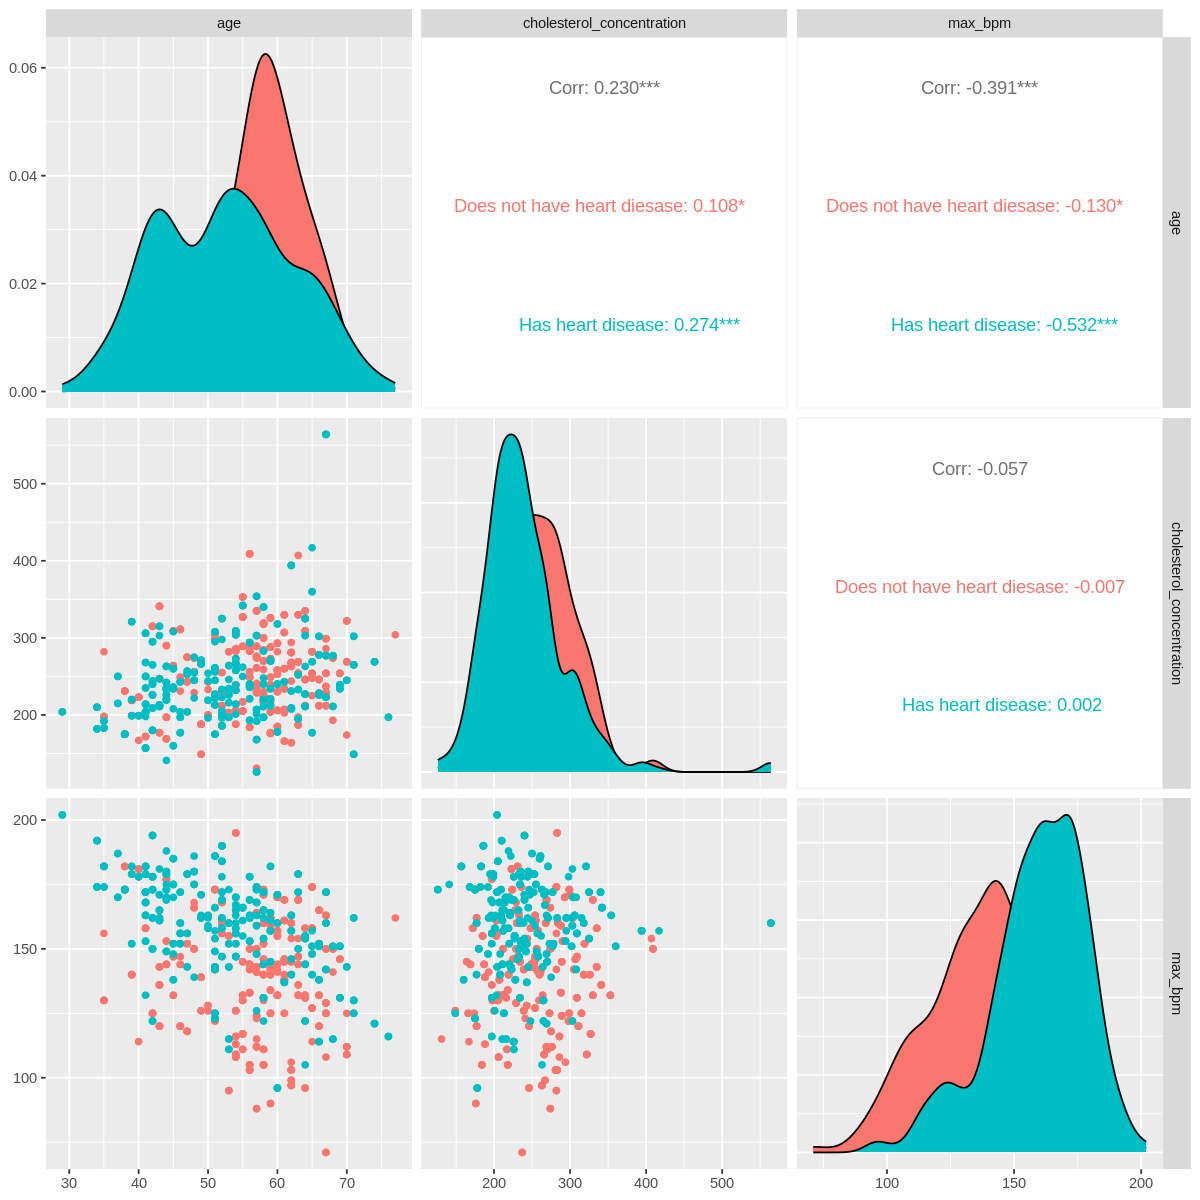

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)
pair_plot <-  mutate(training_set, diagnosis = fct_recode(diagnosis, "Has heart disease" = "Yes", 
                                                          "Does not have heart diesase" = "No")) |>
               ggpairs(aes(color = diagnosis), columns = 1:3) 
pair_plot

**Fig 4:** comparison of our predictors as a pair plot

Above, we have made scatterplots comparing every one of our predictors to each other in pairs.

Most trends between variables seem to have little influence on heart disease diagnosis, however in the plots that compare age to maximum heart rate, we see that most observations of heart disease seem to occur in individuals aged ~35 to ~60 before they become more diffuse. This may be indicative that age influences heart disease diagnosis.

Beyond that, in the plot between maximum heart rate and age we see a weak negative relationship between the variables, we also see that as this relationship progresses the observations progress from being mainly postive for heart disease to negative. This trend may be indicative that older people with lower heart rates are less prone ot heart disease.

From the two observations we have made above, we can begin to establish patterns of expected behaviour in our classifier. That being that older individuals will likely be classified as not having heart disease, and that older people with lower heart rates may be too.

## Data Analysis (precision / recall?)

We will now train and evaluate a KNN classfication model in R using our predictors. When we evaluate its accuracy, we will see how well our predictors truly work and judge whether the classifier is accurate enough to say that they can or cannot predict a diagnosis. Lets start by finding the best K value for our model using our training data.

### **Tuning K: Creating a recipe, model, and workflow to perform cross validation**

Lets do 5 fold cross-validation trying K values from 1 to 25.

In [33]:

grid <- tibble(neighbors = 1:25)

heart_disease_recipe <- recipe(diagnosis ~ ., data = training_set)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_vfold <- vfold_cv(training_set, v = 5, strata = diagnosis)

knn_metrics <- workflow() |>
                 add_recipe(heart_disease_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = heart_vfold, grid = grid) |>
                 collect_metrics()

head(knn_metrics)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9453349,5,0.007537629,Preprocessor1_Model01
1,roc_auc,binary,0.9451566,5,0.007615865,Preprocessor1_Model01
2,accuracy,binary,0.9453349,5,0.007537629,Preprocessor1_Model02
2,roc_auc,binary,0.9305455,5,0.008631764,Preprocessor1_Model02
3,accuracy,binary,0.8229665,5,0.005961790,Preprocessor1_Model03
3,roc_auc,binary,0.8998879,5,0.011552332,Preprocessor1_Model03


**Fig 5:** sample of our tuning metrics.

**Now lets find the K value that makes our classifier as accurate as possible:**

In [34]:
best_k <- knn_results |>
          filter(.metric == "accuracy") |>
          slice_max(mean, n = 1) |>
          select(neighbors, .metric, mean)
best_k

neighbors,.metric,mean
<int>,<chr>,<dbl>
1,accuracy,0.9310321
2,accuracy,0.9310321


**Fig 6:** Observations showing optimal accurate K values, oddly there is more than 1.

Here we see that K = 1 and K = 2 yield the same high accuracy, we will choose K = 1 to prevent any classification ties.

### **Making our final model and training it:**

Lets repeat the above for our tuned K.

In [20]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_fit <- workflow() |>
                 add_recipe(heart_disease_recipe) |>
                 add_model(heart_spec) |>
                 fit(data = training_set)

### **Running our model on testing data and evaluating its performance:**

We will now test our tuned model with the given predictors on the testing set. To evaluate its performance on data it has not seen before, we will yield accuracy metrics and make a confusion matrix.

In [40]:
heart_predictions <- predict(heart_fit, testing_set) |>
                    bind_cols(testing_set)

model_metrics <- metrics(heart_predictions, truth = diagnosis, estimate = .pred_class) |>
                 filter(.metric == "accuracy")

model_conf_mat <- heart_predictions |>
                        conf_mat(truth = diagnosis, estimate = .pred_class) 

#precision
model_metrics
model_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9727626


          Truth
Prediction  No Yes
       No  121   3
       Yes   4 129

**Fig 6:** observation showing the accuracy of our model on testing data.

**Fig 7:** confusion matrix of our model when run on testing data.

Note that "No" means a patient does not have heart disease, and "Yes" means a patient does have it. We see that our model has an accuracy of about 97.3%, a recall of 129/132 = 97.7%, and a precision of 129/133 = 96.9%. However precision is less relevant to our analysis, since with respect to disease we don't care as much about false positives as we do false negatives, which recall accounts for.

## Visualization of our data analysis:

Lets create the same pair plot from above, but this time, lets use the heart_predictions (dataframe holding testing data and our predictions) table and color by our predicted class labels......................................................................

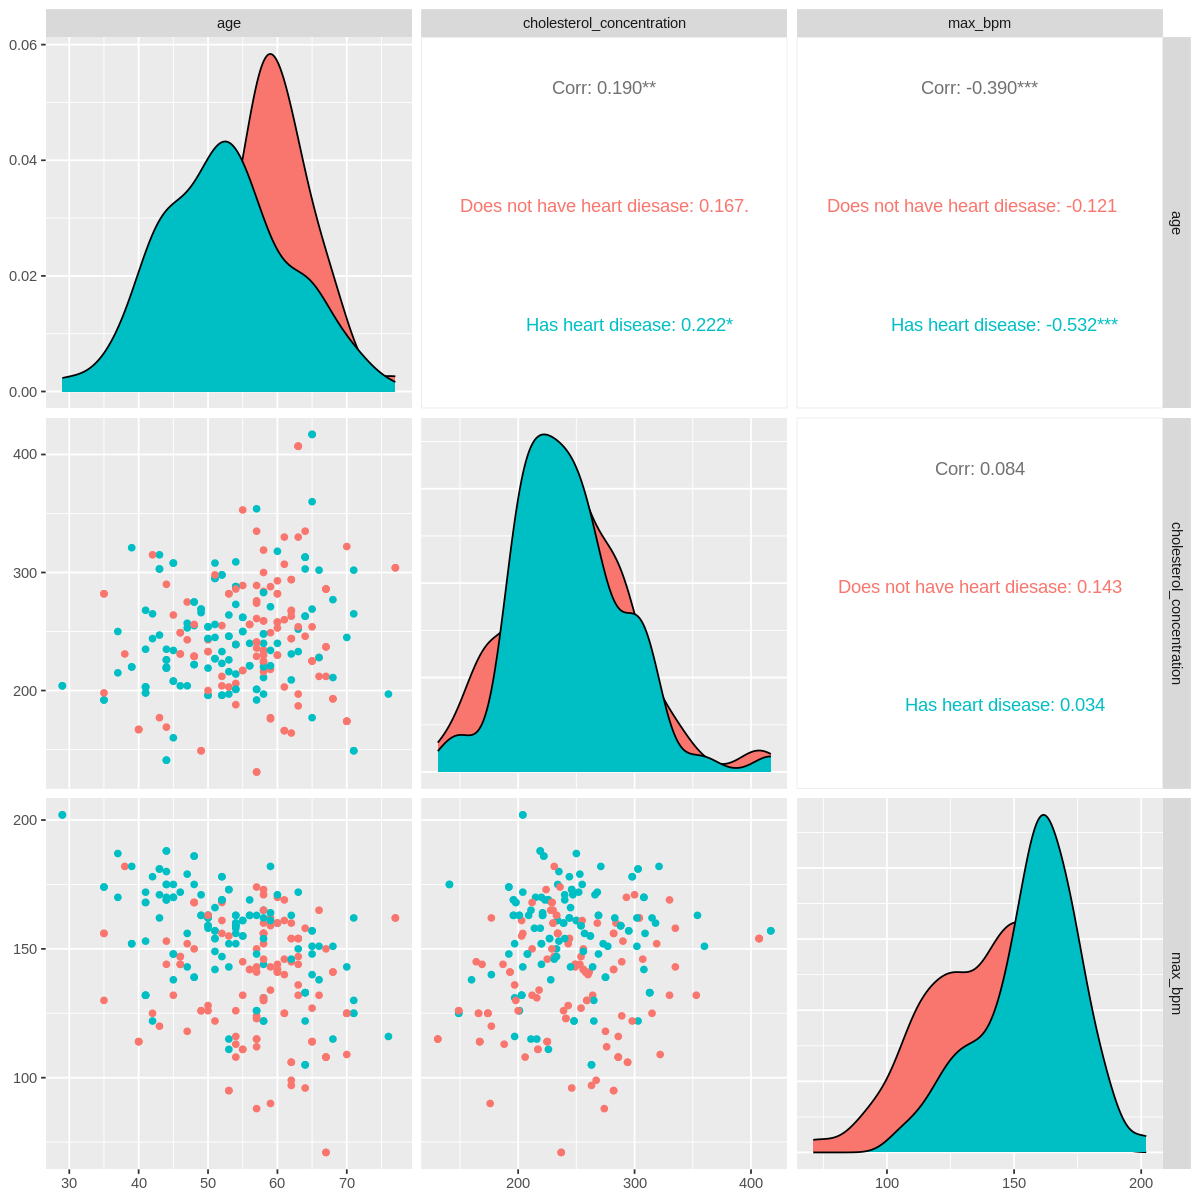

In [43]:
options(repr.plot.width = 10, repr.plot.height = 10)
pair_plot <-  mutate(heart_predictions, .pred_class = fct_recode(diagnosis, "Has heart disease" = "Yes", 
                                                          "Does not have heart diesase" = "No")) |>
               ggpairs(aes(color = .pred_class), columns = 2:4) 
pair_plot

This looks very similar to the plot we made in the exploratory analysis, albeit with our testing data instead. This shows that, to a reasonable extent, our classifier was able to notice the trends in our variables (that we pointed out during our data exploration) and segregate which parts of the trend corresponded to heart disease and which did not.

# Discussion

# References

Format into APA later:
- https://www.codecademy.com/article/eda-prior-to-fitting-a-classification-model
- https://stackoverflow.com/questions/46937614/deselect-subplots-in-ggallyggpairs-by-rows-columns-in-the-ggmatrix-how-to-c